In [3]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import matplotlib.image as mpimg
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os # accessing directory structure
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras
from keras import Model
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers import GlobalMaxPooling2D
tf.__version__


'2.1.0'

In [4]:
# Function definitions

def plot_figures(figures, nrows = 1, ncols=1,figsize=(8, 8)):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows,figsize=figsize)
    for ind,title in enumerate(figures):
        axeslist.ravel()[ind].imshow(cv2.cvtColor(figures[title], cv2.COLOR_BGR2RGB))
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout() # optional
    
def load_image(image_path, img, resized_fac = 1):
    img     = cv2.imread(image_path + img)
    w, h, _ = img.shape
    resized = cv2.resize(img, (int(h*resized_fac), int(w*resized_fac)), interpolation = cv2.INTER_AREA)
    return resized

def get_embedding(model, img_path, img_name):
    # Reshape
    img = image.load_img(img_path + img_name, target_size=(img_width, img_height))
    # img to Array
    x   = image.img_to_array(img)
    # Expand Dim (1, w, h)
    x   = np.expand_dims(x, axis=0)
    # Pre process Input
    x   = preprocess_input(x)
    return model.predict(x).reshape(-1)

def get_recommender(indices, idx, top_n = 5):
    sim_idx    = indices[idx]
        sim_scores = list(enumerate(cosine_sim[sim_idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    idx_rec    = [i[0] for i in sim_scores]
    idx_sim    = [i[1] for i in sim_scores]
    
    return indices.iloc[idx_rec].index, idx_sim

def get_recommendation(similarity_matrix, idx, top_n = 5):
    scores = list(enumerate(similarity_matrix[idx]))
    scores = sorted(scores, key=lambda x: x[1], reverse=True)
    scores = scores[1:top_n + 1]
    return scores

def get_first_filename_startswith(files_dict, prefix):
    files_dict


In [40]:
BASE_PATH = 'D:\\machine-learning\\datasets\\lane-crawford-male-and-female\\'
CATEGORY_MAP_PATH = BASE_PATH + 'categories.json'
IMAGE_MAP_PATH = BASE_PATH + 'images.json'
IMAGE_PATH = BASE_PATH + 'images\\'


In [41]:
# Create data frame from image folder
df = pd.DataFrame(sorted(os.listdir(IMAGE_PATH)), columns=['name'])
df = df.reset_index(drop=True)

#df_image_folder.loc['name':'AAE074_in_l.jpg']
df.loc[df['name']=='AAE082_in_l.jpg']

,name
3,AAE082_in_l.jpg


In [42]:
# Input Shape
#img_width, img_height, _ = load_image(IMAGE_PATH, df.iloc[0].image).shape
#img_width, img_height, _ = load_image(IMAGE_PATH, df.iloc[0].image).shape
#img_width, img_height, _ = 224, 224, 3
img_width, img_height, _ = load_image(IMAGE_PATH, df['name'][0]).shape

# Pre-Trained Model
base_model = ResNet50(weights='imagenet', 
                      include_top=False, 
                      input_shape = (img_width, img_height, 3))
base_model.trainable = False

# Add Layer Embedding
model = keras.Sequential([
    base_model,
    GlobalMaxPooling2D()
])

model.summary()

C:\Users\User\Anaconda3\envs\cnn\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 14, 10, 2048)      23587712  
_________________________________________________________________
global_max_pooling2d_3 (Glob (None, 2048)              0         
Total params: 23,587,712
Trainable params: 0
Non-trainable params: 23,587,712
_________________________________________________________________


In [43]:
# Try out the embedding once, see if it works
#emb = get_embedding(model, IMAGE_PATH, df.iloc[0].image)
emb = get_embedding(model, IMAGE_PATH, df['name'][0])
emb.shape

(2048,)

(432, 314, 3)
[2.200876  1.6214931 0.        ... 4.135437  0.        1.7708943]


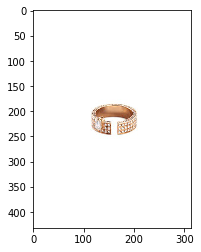

In [44]:
# img_array = load_image(IMAGE_PATH, df.iloc[0].image)
img_array = load_image(IMAGE_PATH, df['name'][0])
plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
print(img_array.shape)
print(emb)

In [45]:
map_embeddings = df[0:5]['name']
print(map_embeddings)

0    AAE074_in_l.jpg
1    AAE075_in_l.jpg
2    AAE079_in_l.jpg
3    AAE082_in_l.jpg
4    AAE083_in_l.jpg
Name: name, dtype: object


In [46]:
%%time
#import swifter

# Source from CSV
# Parallel apply
#df_sample      = df.sample(500)
#map_embeddings = df_sample['image'].apply(lambda img: get_embedding(model, IMAGE_PATH, img))
# Source from image folder directly

# Source from folder directly
# samples = df_image_folder
samples = df#[0:500]
map_embeddings = samples['name'].apply(lambda img: get_embedding(model, IMAGE_PATH, img))
df_embs        = map_embeddings.apply(pd.Series)

print(df_embs.shape)
df_embs.head()

(9846, 2048)
Wall time: 7min 29s


,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,2.200876,1.621493,0.000000,0.000000,11.106973,3.649454,2.261293,12.020161,1.771818,4.786468,...,0.696677,5.237607,7.224769,4.088160,2.676086,1.145499,6.237010,4.135437,0.000000,1.770894
1,0.000000,0.714660,0.000000,0.473273,5.454618,0.000000,1.600913,5.792850,1.968073,4.323955,...,10.373483,14.563172,0.000000,0.000000,2.492492,1.193647,0.033579,0.504035,13.597522,1.847242
2,1.174391,6.534378,2.628541,0.000000,9.018026,2.311334,3.746992,4.529908,2.299128,4.891508,...,0.000000,7.916238,0.000000,2.512881,3.883671,7.262390,14.399537,3.915412,5.392319,1.567581
3,1.438633,6.145528,0.000000,0.000000,7.272207,0.196719,7.878106,3.870676,0.000000,4.731131,...,0.000000,10.877558,7.023214,6.518193,3.275175,0.000000,4.480976,4.571033,0.000000,6.978335
4,0.000000,1.126210,0.762294,0.000000,13.148737,3.709768,2.303971,3.752847,0.000000,4.605767,...,1.548249,38.157150,0.000000,0.000000,2.616910,0.000000,2.988487,0.000000,10.178061,1.782840


In [276]:
# Reduce feature dimension to save up some space and speed up computation
import sys
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
scaler = StandardScaler()
pca = PCA(0.90)

features = map_embeddings.values.tolist()
scaler.fit(features)
normalized_features = scaler.transform(features)

pca.fit(normalized_features)
reduced_features = pca.transform(normalized_features)
print('Original feature length: ' + str(len(features[0])))
print('Reduced feature length: ' + str(len(reduced_features[0])))

#scaler.fit(features)

Original feature length: 2048
Reduced feature length: 789


In [571]:
# Create DataFrame representation of the reduced features, so we can easily index using filename
filenames = df['name'].values

df_reduced = pd.DataFrame(data=reduced_features)
df_reduced['filename'] = filenames

# Create index
# df_reduced.index = filenames
df_reduced.set_index('filename', drop=True)

,0,1,2,3,4,5,6,7,8,9,...,779,780,781,782,783,784,785,786,787,788
filename,,,,,,,,,,,,,,,,,,,,,
AAE074_in_l.jpg,18.270760,-4.333975,9.859982,2.724671,0.150198,0.042369,-6.392938,6.351399,-8.838524,15.884332,...,-0.560467,-0.816807,0.524702,0.346392,0.564572,-1.076371,-0.129152,0.900345,-0.490129,0.224859
AAE075_in_l.jpg,17.215674,-0.991263,-10.333909,1.049149,1.841799,-6.588262,-1.764253,8.113715,-16.602259,-1.625700,...,-0.570163,0.016607,-0.181532,0.278453,0.329342,-0.004652,-0.508207,-0.194287,0.979538,-0.686884
AAE079_in_l.jpg,15.427901,-10.563815,4.834099,2.938670,-1.669555,-2.207786,3.656397,7.075500,-4.694233,-5.432151,...,0.729678,1.063590,0.020738,-0.895800,0.788958,0.961107,-0.663359,-0.160427,-0.052663,0.498866
AAE082_in_l.jpg,21.071512,-2.782047,8.875235,1.560300,-10.930092,0.528659,2.946366,13.943761,-8.655693,15.110814,...,-0.209604,0.319859,-0.783627,-0.627862,-0.548890,-0.660131,0.023054,-0.536567,-1.382571,-0.672451
AAE083_in_l.jpg,22.377684,-9.210634,-7.222810,2.960026,2.756897,-11.306016,8.548221,21.575225,-12.621886,-2.872765,...,-0.162454,0.233651,0.286574,-0.300124,-0.826369,0.652450,0.177866,-0.513116,-0.295566,0.113877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YQQ947_in_l.jpg,16.943293,-15.443192,19.981608,0.556518,-8.401944,-5.210281,6.499472,13.208818,5.561179,3.966379,...,0.352813,0.734101,0.380361,-0.589449,0.886715,0.380779,0.667851,0.167462,-0.576136,0.640235
YQQ950_in_l.jpg,12.972723,-4.586965,1.250103,-1.784017,-1.977043,5.080767,-1.259306,12.693213,0.096070,5.109165,...,0.267372,0.131107,1.441538,-0.874925,1.005421,-1.915748,0.718123,0.452105,-0.603360,0.210334
YQQ956_in_l.jpg,11.377557,-15.032742,8.461320,-3.146150,12.453918,7.700285,0.817894,-5.999972,15.439843,-2.161940,...,0.794328,0.517785,0.087247,1.399530,-0.854982,-0.083838,1.506440,-1.160463,-0.545426,0.757830


In [575]:
# Example on how to access features of products on row 0 - 5
#print(df_reduced.iloc[0:5, 0:788])

# Example on how to find index by filename
df_reduced.loc[df_reduced['filename'] == 'YQQ950_in_l.jpg'].index.values[0]

# Example on how to find features by filename
df_reduced.loc[df_reduced.filename =='YQQ950_in_l.jpg'].iloc[0, 0:789]

# Example on how to find features by row number
df_reduced.iloc[9842, 0:789]

0       12.9727
1      -4.58696
2        1.2501
3      -1.78402
4      -1.97704
         ...   
784    -1.91575
785    0.718123
786    0.452105
787    -0.60336
788    0.210334
Name: 9842, Length: 789, dtype: object

In [590]:
getFilename(22)

'AAJ791_in_l.jpg'

In [598]:
def getFilename(rowNumber):
    return df_reduced.iloc[rowNumber]['filename']

def getRowNumber(filename):
    return df_reduced.loc[df_reduced['filename'] == filename].index.values[0]

In [595]:
# Compute similarity matrix
from sklearn.metrics.pairwise import pairwise_distances

# Calcule DIstance Matriz
cosine_sim = 1-pairwise_distances(reduced_features, metric='cosine')

cosine_sim[:4, :4]

array([[1.        , 0.15298111, 0.10652199, 0.66455121],
       [0.15298111, 1.        , 0.13636942, 0.17301419],
       [0.10652199, 0.13636942, 1.        , 0.30750183],
       [0.66455121, 0.17301419, 0.30750183, 1.        ]])

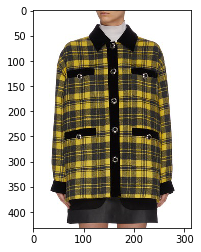

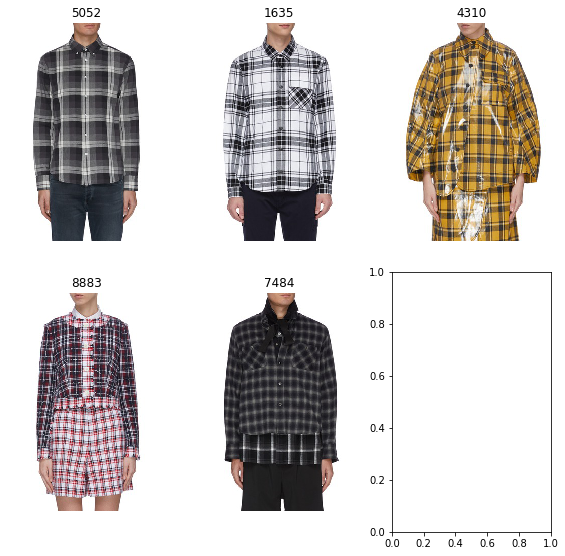

In [613]:
# Test similarity

# Idx Item to Recommender
#idx_ref = 887
idx_ref = getRowNumber('BKK506_in_l.jpg')

# Recommendations
#idx_rec, idx_sim = get_recommender(indices, idx_ref, top_n = 6)

recommendations = get_recommendation(cosine_sim, idx_ref, top_n = 5)


# Plot
#===================
# plt.imshow(cv2.cvtColor(load_image(IMAGE_PATH, df.iloc[idx_ref].image), cv2.COLOR_BGR2RGB))
plt.imshow(cv2.cvtColor(load_image(IMAGE_PATH, getFilename(idx_ref)), cv2.COLOR_BGR2RGB))

# generation of a dictionary of (title, images)
#figures = {'im'+str(i): load_image(IMAGE_PATH,row.image) for i, row in df.loc[idx_rec].iterrows()}
# figures = {'im'+str(i): load_image(IMAGE_PATH,row[0]) for i, row in df_image_folder.loc[idx_rec].iterrows()}

figures = {}
for rec in recommendations:
    figures[rec[0]] = load_image(IMAGE_PATH, df.loc[rec[0]][0])
# figures = {'im'+str(rec[1]): load_image(IMAGE_PATH, df_image_folder.loc[rec[0]][0]) }
#print(figures)
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 3)

In [612]:
# Save Product Features to CSV
IMAGE_FEATURES_PATH = "D:\\machine-learning\\datasets\\lane-crawford-male-and-female\\product-features.csv"
# Avoid truncation
np.set_printoptions(threshold=sys.maxsize)
df_reduced.to_csv(IMAGE_FEATURES_PATH)

In [610]:
# Save Cosine Similarity Matrix
COSINE_SIMILARITY_PATH = "D:\\machine-learning\\datasets\\lane-crawford-male-and-female\\cosine-similarity-matrix.txt"
np.savetxt(COSINE_SIMILARITY_PATH, cosine_sim)